In [4]:
import pandas as pd
import os

In [7]:
# Data loading
path = r'../data/processed/data_processed_v3_NoAcum_Total.csv'
v3_NoAcum_Total_df = pd.read_csv(path)
v3_NoAcum_Total_df.head()

,Year,Week,Date,Entity,Epi_Year,total_cases
0,2014,2,2014-01-13,Aguascalientes,2014,0.0
1,2014,3,2014-01-20,Aguascalientes,2014,0.0
2,2014,4,2014-01-27,Aguascalientes,2014,0.0
3,2014,5,2014-02-03,Aguascalientes,2014,0.0
4,2014,6,2014-02-10,Aguascalientes,2014,0.0


In [9]:
alzheimer_v3_df = v3_NoAcum_Total_df.copy()

def detect_outliers_by_entity(df, column='total_cases'):
    """
    Detects outliers by entity using IQR method
    """
    results = []
    
    for entity in df['Entity'].unique():
        df_entity = df[df['Entity'] == entity]
        
        Q1 = df_entity[column].quantile(0.25)
        Q3 = df_entity[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        outliers = df_entity[
            (df_entity[column] < lower_limit) | 
            (df_entity[column] > upper_limit)
        ]
        
        if len(outliers) > 0:
            results.append({
                'Entity': entity,
                'Total_records': len(df_entity),
                'Num_outliers': len(outliers),
                'Percentage': f"{len(outliers)/len(df_entity)*100:.1f}%",
                'Median': df_entity[column].median(),
                'Max_outlier': outliers[column].max(),
                'Q1': Q1,
                'Q3': Q3,
                'Upper_limit': upper_limit
            })
    
    df_results = pd.DataFrame(results)
    return df_results.sort_values('Num_outliers', ascending=False)

# Execute
outliers_summary = detect_outliers_by_entity(alzheimer_v3_df)
print(outliers_summary)

                 Entity  Total_records  Num_outliers Percentage  Median  \
31            Zacatecas            573           129      22.5%     0.0   
28             Tlaxcala            573           127      22.2%     0.0   
2   Baja California Sur            573           115      20.1%     0.0   
20               Puebla            573            92      16.1%     0.0   
30              Yucatán            573            56       9.8%     1.0   
4               Chiapas            573            53       9.2%     1.0   
15              Morelos            573            53       9.2%     1.0   
23      San Luis Potosí            573            49       8.6%     1.0   
11             Guerrero            573            38       6.6%     0.0   
16               México            573            25       4.4%     2.0   
3              Campeche            573            23       4.0%     0.0   
12              Hidalgo            573            22       3.8%     0.0   
7              Coahuila  

In [10]:
def mark_outliers_by_entity(df, column='total_cases'):
    """
    Adds boolean column 'is_outlier' to DataFrame
    """
    df = df.copy()
    df['is_outlier'] = False
    
    for entity in df['Entity'].unique():
        mask = df['Entity'] == entity
        df_entity = df[mask]
        
        Q1 = df_entity[column].quantile(0.25)
        Q3 = df_entity[column].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_limit = Q1 - 1.5 * IQR
        upper_limit = Q3 + 1.5 * IQR
        
        outlier_mask = (df_entity[column] < lower_limit) | (df_entity[column] > upper_limit)
        df.loc[mask, 'is_outlier'] = outlier_mask.values
    
    return df

# Execute
alzheimer_v3_df = mark_outliers_by_entity(alzheimer_v3_df)

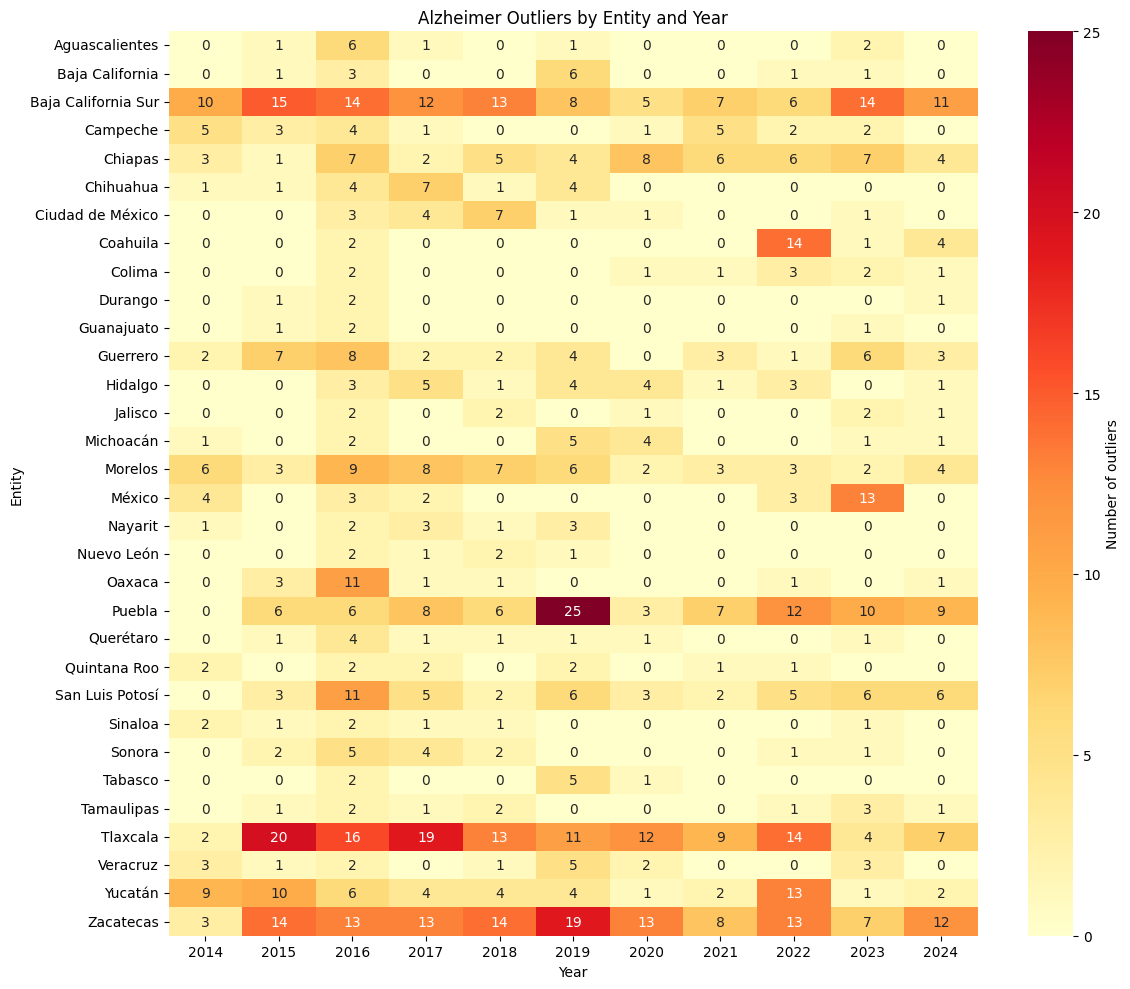

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

# Ensure you have the is_outlier column
df = mark_outliers_by_entity(alzheimer_v3_df)

# Create matrix for heatmap (outliers by year and entity)
pivot = df.pivot_table(
    index='Entity', 
    columns='Year', 
    values='is_outlier', 
    aggfunc='sum'  # Count outliers per year
)

# Visualize
plt.figure(figsize=(12, 10))
sns.heatmap(pivot, cmap='YlOrRd', annot=True, fmt='g', 
            cbar_kws={'label': 'Number of outliers'})
plt.title('Alzheimer Outliers by Entity and Year')
plt.xlabel('Year')
plt.ylabel('Entity')
plt.tight_layout()
plt.show()

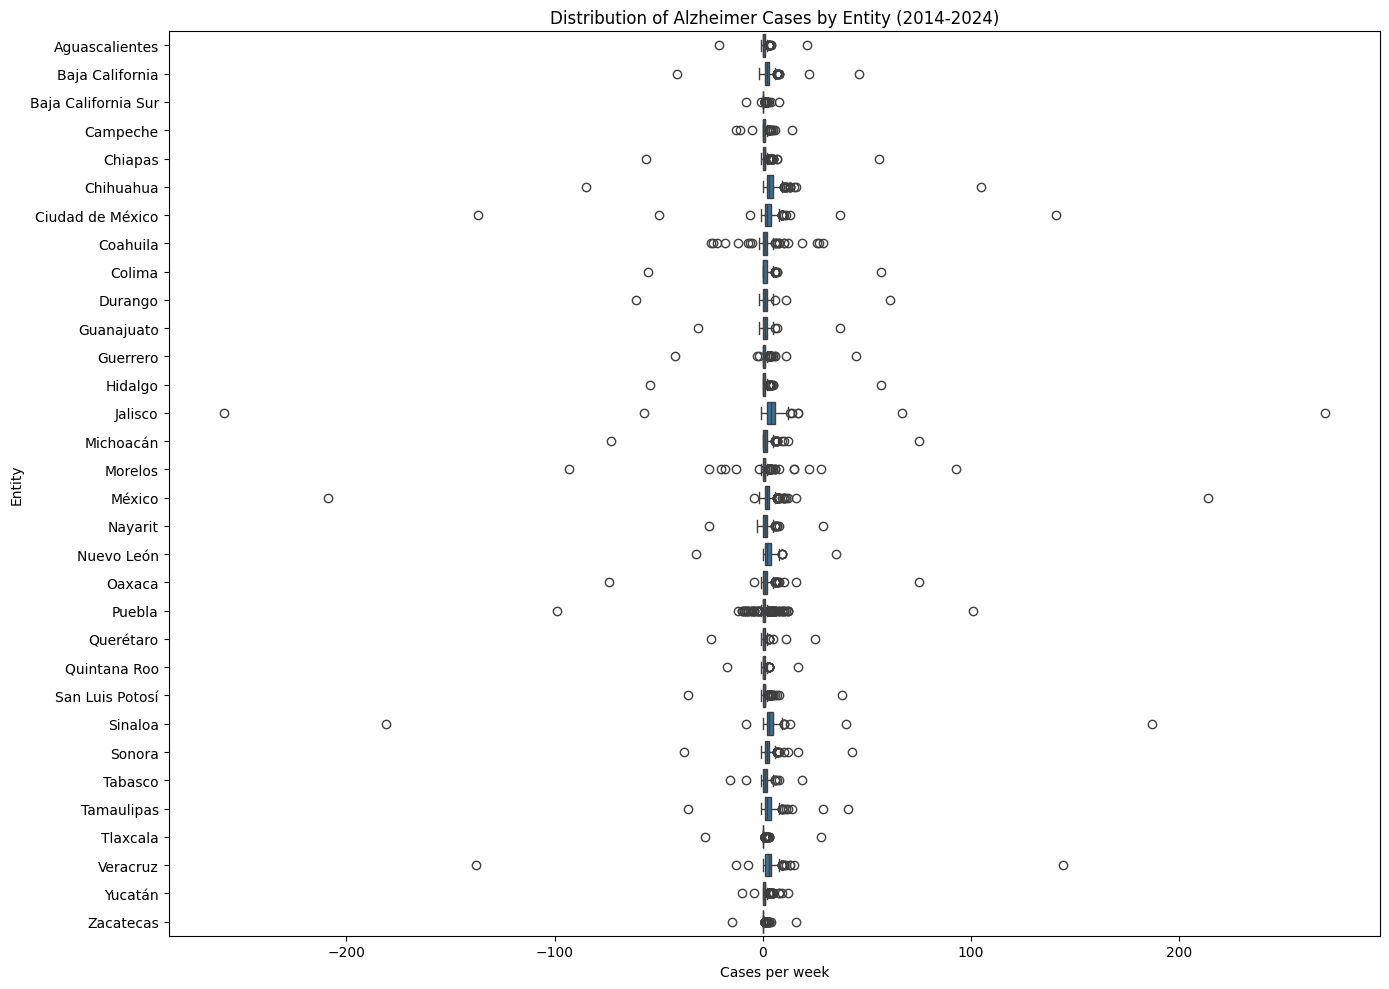

In [12]:
plt.figure(figsize=(14, 10))
sns.boxplot(data=df, y='Entity', x='total_cases', orient='h')
plt.title('Distribution of Alzheimer Cases by Entity (2014-2024)')
plt.xlabel('Cases per week')
plt.ylabel('Entity')
plt.tight_layout()
plt.show()